# Model making

Create full data set for all states and don't exclude TN 

read cancer data set: state, county, avg_cost
income data - create income agg data by state and county


In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#import graphviz
from IPython.display import SVG

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [292]:
#Create a DataFrame, ha_costs_df, from the mmd_heart_attack_data.csv file.
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv')
#Look at the head and tail of the DataFrame
ha_costs_df.head(-1)
ha_costs_df['state'].value_counts()
ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'}, inplace = True)
ha_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470


In [293]:
ha_costs_df.shape

(2656, 17)

In [294]:
#Create a DataFrame, cancer_costs_df, from the mmd_cancer_data.csv file.
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
#Look at the head and tail of the DataFrame
cancer_costs_df.head(-1)
cancer_costs_df['state'].value_counts()
cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'}, inplace = True)
cancer_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293


In [295]:
cancer_costs_df.shape

(3165, 17)

In [296]:
#Create a DataFrame, income_df, from the irs_county_2016.csv file.
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df.info()
income_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25536 entries, 0 to 25535
Columns: 148 entries, STATEFIPS to A11902
dtypes: int64(146), object(2)
memory usage: 28.8+ MB


,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,N2,NUMDEP,TOTAL_VITA,VITA,TCE,VITA_EIC,RAL,RAC,ELDERLY,A00100,...,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,Alabama,1,26450,14680,9740,680,17780,40700,5590,260,190,70,0,0,750,13000,-1679314,...,1000,1033,490,769,1300,1266,3110,2297,700,443,4300,9256,70,57,0,0,2590,3685,11510,35079


In [297]:
income_df.shape

(25536, 148)

In [298]:
#Keep only the following columns:
    #['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']
income_df = income_df.loc[:, ['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 
                              'NUMDEP', 'ELDERLY','A00100', 'N02650', 'A02650', 'N02300', 'A02300']]

In [299]:
#Rename columns
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 
                     'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 
                     'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 
                     'unemployment_comp']
income_df.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AL,Alabama,1,26450,14680,9740,680,40700,5590,13000,-1679314,19140,-1657452,60,203


In [300]:
# Create agg income by state and county.
income_county_agg = income_df.groupby(['state', 'county']).sum() 
income_county_agg.head(1)

,,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
state,county,,,,,,,,,,,,,
AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460


In [301]:
#Be sure to also `reset_index()` so that our aggregated data is re-indexed to begin at 0. 
income_county_agg = income_county_agg.reset_index()
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460


In [302]:
#DataFrame which gives the approximate average household income for each county. 
#Calculate this as 1000*`total_inc_amt` / `return_count
income_county_agg['approx_avg_income']= 1000 * income_county_agg['total_inc_amt']/income_county_agg['return_count']
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68543.715345


In [303]:
#Import geographic new data set
geog_df = pd.read_csv('../data/geographic_profile_update.csv')
geog_df.head(1)

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),Percent Below Federal Poverty Level (1y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of +4 Person Households with +3 Workers (5y Avg.),Percent of +4 Person Households with 1 Worker (5y Avg.),Percent of +4 Person Households with 2 Workers (5y Avg.),Percent of +4 Person Households with No Workers (5y Avg.),Percent of 1 Person Households with 1 Worker (5y Avg.),Percent of 1 Person Households with No Workers (5y Avg.),Percent of 2 Person Households with 1 Worker (5y Avg.),Percent of 2 Person Households with 2 Workers (5y Avg.),Percent of 2 Person Households with No Workers (5y Avg.),Percent of 3 Person Households with 1 Worker (5y Avg.),Percent of 3 Person Households with 2 Workers (5y Avg.),Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,AL,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,NaN,0.12266,0.118907,0.319251,0.486714,0.075129,0.458004,0.541996,0.309853,0.357425,0.332722,0.287451,0.505256,0.101183,0.10611,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252


In [304]:
#Import geographic new data set
health_outcomes = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 5, header = [0,1])
health_outcomes.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                FIPS              State             County   
0               1001            Alabama            Autauga   
1               1003            Alabama            Baldwin   
2               1005            Alabama            Barbour   
3               1007            Alabama               Bibb   
4               1009            Alabama             Blount   

  Premature age-adjusted mortality                                      \
                          # Deaths Age-Adjusted Mortality 95% CI - Low   
0                            827.0                  449.6        418.5   
1                           2753.0                  351.3        337.5   
2                            418.0                  433.6        390.5   
3                            408.0                  529.1        476.7   
4                            996.0                  480.2        449.2   

                                                \
  95% CI - High Age-Adjusted Mortality (Black)   
0         480.7                          531.7   
1         365.1                          517.8   
2         476.6                          477.0   
3         581.4                          630.4   
4         511.2                            NaN   

                                                                    \
  Age-Adjusted Mortality (Hispanic) Age-Adjusted Mortality (White)   
0                               NaN                          444.9   
1                             111.1                          349.3   
2                               NaN                          394.7   
3                               NaN                          526.6   
4                               NaN                            NaN   

  Child mortality                                                  \
         # Deaths Child Mortality Rate 95% CI - Low 95% CI - High   
0            31.0            56.186903         38.2          79.8   
1            85.0            47.688777         38.1          59.0   
2            15.0            66.595631         37.3         109.8   
3            22.0           116.315956         72.9         176.1   
4            30.0            55.375074         37.4          79.1   

                                                                \
  Child Mortality Rate (Black) Child Mortality Rate (Hispanic)   
0                          NaN                             NaN   
1                    87.008289                             NaN   
2                          NaN                             NaN   
3                          NaN                             NaN   
4                          NaN                             NaN   

                               Infant mortality                        \
  Child Mortality Rate (White)         # Deaths Infant Mortality Rate   
0                          NaN             34.0              7.718502   
1                     44.47218             85.0              5.545407   
2                          NaN              NaN                   NaN   
3                          NaN             25.0             14.775414   
4                          NaN             25.0              5.294367   

                ...  Demographics                                        \
  95% CI - Low  ... % 65 and over # African American % African American   
0          5.3  ...     14.728598              10556          19.048650   
1          4.4  ...     19.708194              18860           9.042831   
2          NaN  ...     18.016561              12337          47.513961   
3          9.6  ...     15.430817               4895          21.618160   
4          3.4  ...     17.986621                828           1.434909   

                                                                             \
  # American Indian/Alaskan Native % American Indian/Alaskan Native # Asian   
0                              269                         0.48

In [305]:
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in health_outcomes.columns.values]

# Then get rid of the "Unnamed" portion for the first 3 columns
col_names[0:3] = ['FIPS', 'state', 'county']
col_names

['FIPS',
 'state',
 'county',
 'Premature age-adjusted mortality # Deaths',
 'Premature age-adjusted mortality Age-Adjusted Mortality',
 'Premature age-adjusted mortality 95% CI - Low',
 'Premature age-adjusted mortality 95% CI - High',
 'Premature age-adjusted mortality Age-Adjusted Mortality (Black)',
 'Premature age-adjusted mortality Age-Adjusted Mortality (Hispanic)',
 'Premature age-adjusted mortality Age-Adjusted Mortality (White)',
 'Child mortality # Deaths',
 'Child mortality Child Mortality Rate',
 'Child mortality 95% CI - Low',
 'Child mortality 95% CI - High',
 'Child mortality Child Mortality Rate (Black)',
 'Child mortality Child Mortality Rate (Hispanic)',
 'Child mortality Child Mortality Rate (White)',
 'Infant mortality # Deaths',
 'Infant mortality Infant Mortality Rate',
 'Infant mortality 95% CI - Low',
 'Infant mortality 95% CI - High',
 'Infant mortality Infant Mortality Rate (Black)',
 'Infant mortality Infant Mortality Rate (Hispanic)',
 'Infant mortality Inf

In [306]:
health_outcomes.columns = col_names
health_outcomes.head()

,FIPS,state,county,Premature age-adjusted mortality # Deaths,Premature age-adjusted mortality Age-Adjusted Mortality,Premature age-adjusted mortality 95% CI - Low,Premature age-adjusted mortality 95% CI - High,Premature age-adjusted mortality Age-Adjusted Mortality (Black),Premature age-adjusted mortality Age-Adjusted Mortality (Hispanic),Premature age-adjusted mortality Age-Adjusted Mortality (White),Child mortality # Deaths,Child mortality Child Mortality Rate,Child mortality 95% CI - Low,Child mortality 95% CI - High,Child mortality Child Mortality Rate (Black),Child mortality Child Mortality Rate (Hispanic),Child mortality Child Mortality Rate (White),Infant mortality # Deaths,Infant mortality Infant Mortality Rate,Infant mortality 95% CI - Low,...,Demographics % 65 and over,Demographics # African American,Demographics % African American,Demographics # American Indian/Alaskan Native,Demographics % American Indian/Alaskan Native,Demographics # Asian,Demographics % Asian,Demographics # Native Hawaiian/Other Pacific Islander,Demographics % Native Hawaiian/Other Pacific Islander,Demographics # Hispanic,Demographics % Hispanic,Demographics # Non-Hispanic White,Demographics % Non-Hispanic White,Demographics # Not Proficient in English,Demographics % Not Proficient in English,Demographics 95% CI - Low,Demographics 95% CI - High,Demographics % Female,Demographics # Rural,Demographics % Rural
0,1001,Alabama,Autauga,827.0,449.6,418.5,480.7,531.7,NaN,444.9,31.0,56.186903,38.2,79.8,NaN,NaN,NaN,34.0,7.718502,5.3,...,14.728598,10556,19.048650,269,0.485419,632,1.140465,56,0.101054,1490,2.688754,41562,75.000000,432,0.832739,0.457689,1.207789,51.288437,22921.0,42.002162
1,1003,Alabama,Baldwin,2753.0,351.3,337.5,365.1,517.8,111.1,349.3,85.0,47.688777,38.1,59.0,87.008289,NaN,44.47218,85.0,5.545407,4.4,...,19.708194,18860,9.042831,1608,0.770990,2242,1.074975,124,0.059454,9211,4.416411,173529,83.202198,1540,0.818809,0.508623,1.128996,51.457833,77060.0,42.279099
2,1005,Alabama,Barbour,418.0,433.6,390.5,476.6,477.0,NaN,394.7,15.0,66.595631,37.3,109.8,NaN,NaN,NaN,NaN,NaN,NaN,...,18.016561,12337,47.513961,164,0.631619,117,0.450607,45,0.173310,1094,4.213364,12061,46.450992,382,1.519370,0.790980,2.247760,46.932409,18613.0,67.789635
3,1007,Alabama,Bibb,408.0,529.1,476.7,581.4,630.4,NaN,526.6,22.0,116.315956,72.9,176.1,NaN,NaN,NaN,25.0,14.775414,9.6,...,15.430817,4895,21.618160,86,0.379808,45,0.198737,27,0.119242,566,2.499669,16850,74.415934,96,0.448137,0.000000,1.041411,46.363114,15663.0,68.352607
4,1009,Alabama,Blount,996.0,480.2,449.2,511.2,NaN,NaN,NaN,30.0,55.375074,37.4,79.1,NaN,NaN,NaN,25.0,5.294367,3.4,...,17.986621,828,1.434909,362,0.627340,153,0.265146,65,0.112644,5233,9.068695,50472,87.467073,1018,1.878506,1.332987,2.424025,50.613476,51562.0,89.951502


Merge heart attack and cancer data sets

In [307]:
cancer_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293


In [308]:
ha_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470


In [309]:
ha_cancer_costs_df = pd.merge(cancer_costs_df.loc[:,['state', 'county', 'urban', 'cancer_avg_cost']], 
                                     ha_costs_df.loc[:,['state', 'county', 'ha_avg_cost']], on=['state', 'county'], how='inner')
ha_cancer_costs_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,Urban,19293,40470


In [310]:
ha_cancer_costs_df.shape

(2656, 5)

In [311]:
##Create `state_dict`, a dictionary that uses the provides descripton of state abbreviation
#import state abbreviation dataset
state_abb_df = pd.read_csv('../data/state_abbrev.csv')
state_abb_df.head(1)

,name,abbrev
0,ALABAMA,AL


In [312]:
ha_cancer_costs_df.head()

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,Urban,19293,40470
1,ALABAMA,Baldwin County,Rural,17151,36615
2,ALABAMA,Barbour County,Rural,19469,46509
3,ALABAMA,Bibb County,Urban,17234,42949
4,ALABAMA,Blount County,Urban,20317,50067


In [313]:
ha_cancer_costs_df['state']=ha_cancer_costs_df.state.map(state_abb_df.set_index('name')['abbrev'].to_dict())

In [314]:
ha_cancer_costs_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,AL,Autauga County,Urban,19293,40470


In [315]:
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68543.715345


In [316]:
income_sub = income_county_agg[['county', 'approx_avg_income']]

In [317]:
ha_cancer_costs_incomeavg_df = pd.merge(ha_cancer_costs_df, 
                                        income_county_agg.loc[:,['state', 'county', 'approx_avg_income', 'agi', 'income_bucket']], on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36


In [318]:
ha_cancer_costs_incomeavg_df.shape

(2619, 8)

In [319]:
geog_df.head(1)

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),Percent Below Federal Poverty Level (1y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of +4 Person Households with +3 Workers (5y Avg.),Percent of +4 Person Households with 1 Worker (5y Avg.),Percent of +4 Person Households with 2 Workers (5y Avg.),Percent of +4 Person Households with No Workers (5y Avg.),Percent of 1 Person Households with 1 Worker (5y Avg.),Percent of 1 Person Households with No Workers (5y Avg.),Percent of 2 Person Households with 1 Worker (5y Avg.),Percent of 2 Person Households with 2 Workers (5y Avg.),Percent of 2 Person Households with No Workers (5y Avg.),Percent of 3 Person Households with 1 Worker (5y Avg.),Percent of 3 Person Households with 2 Workers (5y Avg.),Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,AL,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,NaN,0.12266,0.118907,0.319251,0.486714,0.075129,0.458004,0.541996,0.309853,0.357425,0.332722,0.287451,0.505256,0.101183,0.10611,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252


In [320]:
ha_cancer_costs_incomeavg_geog_df = pd.merge(ha_cancer_costs_incomeavg_df, 
                                        geog_df.loc[:,['state', 'county', 'Unemployment Rate (5y Avg.)', 
                                                       'Percent Below Federal Poverty Level (5y Avg.)', 
                                                       'Percent of Senior Population Below Federal Poverty Level (5y Avg.)',
                                                      'Senior Unemployment Rate (5y Avg.)',
                                                      'Median Household Income (5y Average)']], 
                                             on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_geog_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average)
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0


In [321]:
ha_cancer_costs_incomeavg_geog_df.shape

(2618, 13)

In [322]:
#Creating specific demographic data from health outcomes dataset, which will be used in merge
health_outcomes_1 = health_outcomes[['state', 'county', 'Demographics % Hispanic', 'Demographics % Female',
                                     'Uninsured adults # Uninsured', 'Frequent physical distress % Frequent Physical Distress',
                                                      'Uninsured adults % Uninsured',
                                    'Frequent mental distress % Frequent Mental Distress',
                                    'Demographics % Not Proficient in English',
                                    'Diabetes prevalence % Diabetic',
                                     'Food insecurity % Food Insecure',
                                     'Insufficient sleep % Insufficient Sleep',
                                     'Demographics % African American',
                                     'Limited access to healthy foods % Limited Access']]
health_outcomes_1.head(2)

,state,county,Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access
0,Alabama,Autauga,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.048650,11.991125
1,Alabama,Baldwin,4.416411,51.457833,17437.0,12.622002,14.719861,12.822558,0.818809,11.1,13.0,33.305868,9.042831,5.424427


In [323]:
#chnaging the state name to abreviation format to ensure merge is successful
health_outcomes_1['state']=health_outcomes_1.state.str.upper().map(state_abb_df.set_index('name')['abbrev'].to_dict())
health_outcomes_1.head(1)

,state,county,Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access
0,AL,Autauga,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125


In [324]:
#Adding County in the County column to ensure merge is successfull
health_outcomes_1.county = health_outcomes_1.county + ' County'

In [325]:
ha_cancer_costs_incomeavg_geog_1_df = pd.merge(ha_cancer_costs_incomeavg_geog_df, 
                                        health_outcomes_1, 
                                             on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125


In [326]:
ha_cancer_costs_incomeavg_geog_1_df.shape

(2524, 25)

In [327]:
ha_cancer_costs_incomeavg_geog_1_df['ha_cost_income_ratio'] = ha_cancer_costs_incomeavg_geog_1_df.ha_avg_cost / ha_cancer_costs_incomeavg_geog_1_df.approx_avg_income
ha_cancer_costs_incomeavg_geog_1_df['cancer_cost_income_ratio'] = ha_cancer_costs_incomeavg_geog_1_df.cancer_avg_cost / ha_cancer_costs_incomeavg_geog_1_df.approx_avg_income
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496


In [328]:
ha_cancer_costs_incomeavg_geog_1_df.cancer_cost_income_ratio.mean()


0.40852121222765314

In [329]:
ha_cancer_costs_incomeavg_geog_1_df['condition'] = ha_cancer_costs_incomeavg_geog_1_df.cancer_cost_income_ratio.mean()
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521


In [330]:
#creating depedendent variable
#average cost for cancer care is above the average cost or equal to or below the average cost
ha_cancer_costs_incomeavg_geog_1_df['cancer_cost_income_ratio_above_avg_y'] = ha_cancer_costs_incomeavg_geog_1_df.cancer_cost_income_ratio > ha_cancer_costs_incomeavg_geog_1_df.condition
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521,False


In [331]:
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521,False


In [335]:
#log reg model
X = ha_cancer_costs_incomeavg_geog_1_df[['urban',
                                        'Uninsured adults % Uninsured',
                                        'Frequent physical distress % Frequent Physical Distress',
                                         'Diabetes prevalence % Diabetic',
                                         'Food insecurity % Food Insecure']]
#tested these variables: 
#'Insufficient sleep % Insufficient Sleep',  'Demographics % African American', 'Median Household Income (5y Average)',                                     
#'ha_cost_income_ratio', 'Frequent mental distress % Frequent Mental Distress', 'Demographics % Not Proficient in English'
#'Percent Below Federal Poverty Level (5y Avg.)','Demographics % Hispanic',  'Demographics % Female' 
#'Senior Unemployment Rate (5y Avg.)']]
y = ha_cancer_costs_incomeavg_geog_1_df['cancer_cost_income_ratio_above_avg_y']

In [336]:
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

ValueError: could not convert string to float: 'Urban'

In [282]:
logistic_model.coef_[0]

array([-1.17697018,  0.02961913,  0.46116873,  0.11549581,  0.03687876])

In [283]:
#Machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [284]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

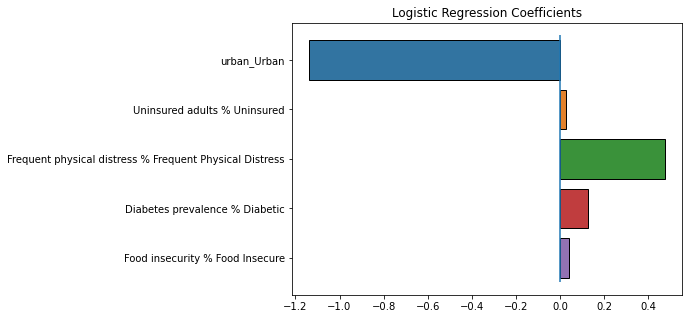

In [285]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')

ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

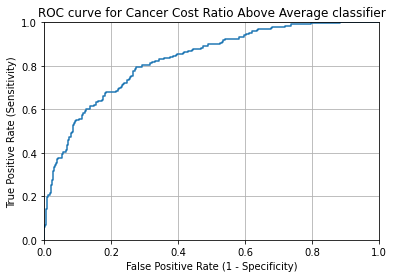

In [286]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Ratio Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [287]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8296059637912673


In [288]:
#Model accuracy (Full Model)
y_pred = logistic_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7416798732171157

# Performing Descriptives for the presentaiotn for TN STATE ONLY!!!

important variables for Cancer cost ratio based on whole US Data:
1. heart attack cost
2. Urban
3. Percent Below Federal Poverty Level (5y Avg.) 
4. Senior Unemployment Rate (5y Avg.)
Females and Hispanics don't matter! We can show it

In [337]:
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521,False


In [345]:
#Restrciting the data to TN State for presentation
TN_df = ha_cancer_costs_incomeavg_geog_1_df['state'] == 'TN'
TN_Full_df = ha_cancer_costs_incomeavg_geog_1_df[TN_df]
pd.set_option('display.max_columns', 40)
TN_Full_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y
1950,TN,Anderson County,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.86757,11.7,14.4,35.819313,3.954646,9.359187,0.800807,0.289496,0.408521,False


In [346]:
TN_Full_df.index

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
            2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
            2038, 2039, 2040],
           dtype='int64')

In [347]:
TN_Full_df.shape

(91, 29)

In [370]:
TN_Full_df = pd.merge(TN_Full_df, income_sub, on = 'county', how = 'inner')
TN_Full_df2

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income_x,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,approx_avg_income_y,approx_avg_income_x,county2,approx_avg_income_y
0,TN,Anderson County,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,44540.114613
1,TN,Anderson County,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,52034.626301
2,TN,Anderson County,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,52225.678056
3,TN,Anderson County,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,53382.385535
4,TN,Anderson County,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,45069.329897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147105,TN,Wilson County,Urban,20618,52387,67410.847880,4256127,36,0.053647,0.090989,0.056165,0.015241,63426.0,4.002079,50.986963,8947.0,11.134040,11.409807,11.581610,0.670806,11.9,10.6,33.262627,6.673395,3.886270,0.777130,0.305856,0.408521,False,64183.852420,67410.847880,Wilson,64183.852420
147106,TN,Wilson County,Urban,20618,52387,67410.847880,4256127,36,0.053647,0.090989,0.056165,0.015241,63426.0,4.002079,50.986963,8947.0,11.134040,11.409807,11.581610,0.670806,11.9,10.6,33.262627,6.673395,3.886270,0.816202,0.321233,0.408521,False,64183.852420,64183.852420,Wilson,44913.541667
147107,TN,Wilson County,Urban,20618,52387,67410.847880,4256127,36,0.053647,0.090989,0.056165,0.015241,63426.0,4.002079,50.986963,8947.0,11.134040,11.409807,11.581610,0.670806,11.9,10.6,33.262627,6.673395,3.886270,0.816202,0.321233,0.408521,False,64183.852420,64183.852420,Wilson,46214.269631
147108,TN,Wilson County,Urban,20618,52387,67410.847880,4256127,36,0.053647,0.090989,0.056165,0.015241,63426.0,4.002079,50.986963,8947.0,11.134040,11.409807,11.581610,0.670806,11.9,10.6,33.262627,6.673395,3.886270,0.816202,0.321233,0.408521,False,64183.852420,64183.852420,Wilson,67410.847880


In [373]:
TN_Full_df2_clean = TN_Full_df2.groupby('county').first().reset_index()
TN_Full_df2_clean.head(5)

,county,state,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income_x,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,approx_avg_income_y,approx_avg_income_x,county2,approx_avg_income_y
0,Anderson County,TN,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,44540.114613
1,Bedford County,TN,Rural,19219,43661,47127.581262,971152,36,0.061397,0.162543,0.072189,0.030724,43819.0,11.787128,50.840283,5980.0,14.448689,21.562759,13.911517,3.232674,12.5,13.2,36.252518,7.370904,6.622556,0.934468,0.411341,0.408521,False,46722.832244,46722.832244,Bedford,46722.832244
2,Benton County,TN,Rural,21315,44423,41296.671710,269227,36,0.110525,0.226498,0.149043,0.038647,33611.0,2.285500,50.693143,1648.0,15.795907,17.870310,15.192168,1.369241,14.6,15.7,37.092253,2.435369,6.564157,0.424309,0.203591,0.408521,True,104695.022984,104695.022984,Benton,104695.022984
3,Bledsoe County,TN,Rural,19250,41240,39743.640351,178860,36,0.093023,0.237262,0.145402,0.070796,38535.0,2.166951,41.574106,1259.0,15.720713,17.645410,14.761657,0.386188,13.7,15.7,36.760964,6.678024,1.637994,1.037650,0.484354,0.408521,True,39743.640351,39743.640351,Bledsoe,39743.640351
4,Blount County,TN,Urban,17073,38968,56786.162888,3333654,36,0.065083,0.135709,0.076359,0.029956,49532.0,3.203544,51.478977,10141.0,13.260458,13.410828,13.048794,0.828124,14.6,12.2,33.487183,2.873242,11.627353,0.789894,0.346075,0.408521,False,49333.197648,49333.197648,Blount,49333.197648


In [374]:
TN_Full_df2_clean.shape

(91, 33)

In [375]:
TN_Full_df2_clean['ha_cost_income_ratio'] = TN_Full_df2_clean['ha_avg_cost'] / TN_Full_df2_clean['approx_avg_income_x']
TN_Full_df2_clean['cancer_cost_income_ratio'] = TN_Full_df2_clean['cancer_avg_cost'] / TN_Full_df2_clean['approx_avg_income_x']
TN_Full_df2_clean

TypeError: '<' not supported between instances of 'str' and 'int'

<Figure size 1080x720 with 0 Axes>

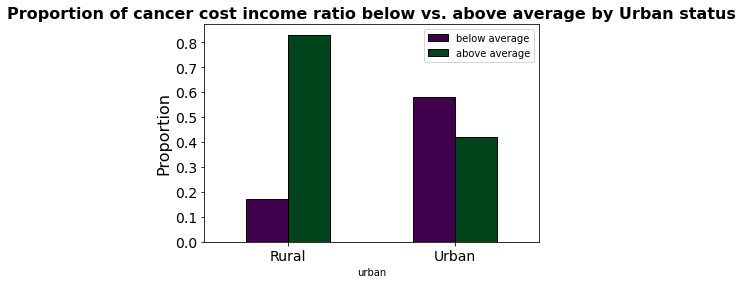

In [412]:
#Perfroming explorating analysis for important variables identified by full US dataset
plt.figure(figsize = (15, 10))
pd.crosstab(TN_Full_df2_clean['urban'], TN_Full_df2_clean['cancer_cost_income_ratio_above_avg_y'], 
            normalize='index').plot(kind = 'bar', edgecolor = 'black', cmap = 'PRGn')
plt.xticks(rotation = 0, fontsize = 14)
plt.ylabel('Proportion', fontsize = 16)
plt.yticks(fontsize = 14)
plt.legend(loc = 'upper right', labels = ['below average', 'above average'])
plt.title('Proportion of cancer cost income ratio below vs. above average by Urban status', fontsize = 16, fontweight = 'bold');

In [ ]:
plt.figure(figsize = (15, 10))
pd.crosstab(TN_Full_df2_clean['urban'], TN_Full_df2_clean['cancer_cost_income_ratio_above_avg_y'], 
            normalize='index').plot(kind = 'bar', edgecolor = 'black', cmap = 'PRGn')
plt.xticks(rotation = 0, fontsize = 14)
plt.ylabel('Proportion', fontsize = 16)
plt.yticks(fontsize = 14)
plt.legend(loc = 'upper right', labels = ['below average', 'above average'])
plt.title('Proportion of cancer cost income ratio below vs. above average by Urban status', fontsize = 16, fontweight = 'bold');

In [351]:
import geopandas as gpd
counties = gpd.read_file('../data/county/tncounty.shp')
counties.head(2)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."


In [352]:
counties.shape

(95, 6)

In [358]:
TN_Full_df['county2'] = TN_Full_df.county.str[:-7]

In [359]:
geo_tn = pd.merge(counties, TN_Full_df, left_on = 'NAME', right_on = 'county2')
geo_tn.head(5)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income_x,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,approx_avg_income_y,approx_avg_income,county2
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,0.435987,0.207276,0.408521,True,112994.245993,112994.245993,Chester
1,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,1.238155,0.588641,0.408521,True,112994.245993,39788.239487,Chester
2,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,1.141767,0.542817,0.408521,True,112994.245993,43147.147147,Chester
3,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,0.435987,0.207276,0.408521,True,39788.239487,112994.245993,Chester
4,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,1.238155,0.588641,0.408521,True,39788.239487,39788.239487,Chester


In [390]:
geo_tn2 = geo_tn.rename(columns = {'Uninsured adults % Uninsured' : 'Uninsured_adults_per_Uninsured', 'Diabetes prevalence % Diabetic' : 'Diabetes_prev_perc', 'Food insecurity % Food Insecure' : 'Food_insecure_perc', 'Frequent physical distress % Frequent Physical Distress' : 'Freq_phys_distress_perc'})
geo_tn2.head(2)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income_x,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Freq_phys_distress_perc,Uninsured_adults_per_Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes_prev_perc,Food_insecure_perc,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,approx_avg_income_y,approx_avg_income,county2
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,0.435987,0.207276,0.408521,True,112994.245993,112994.245993,Chester
1,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",TN,Chester County,Urban,23421,49264,43147.147147,282970,36,0.107435,0.179348,0.136414,0.101877,42376.0,2.366355,52.031169,1436.0,13.583716,15.052411,13.727882,0.397626,13.1,15.5,34.765061,8.944021,5.721717,1.238155,0.588641,0.408521,True,112994.245993,39788.239487,Chester


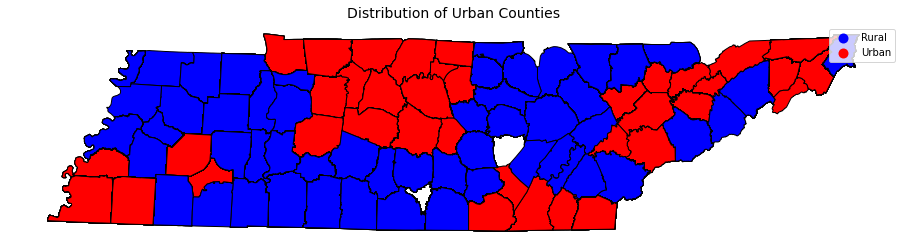

In [395]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn2[geo_tn2.urban.notnull()].plot(column = 'urban',
                    cmap = 'bwr',
                    edgecolor = 'black',
                    legend = True,
                    ax = ax)
plt.title('Distribution of Urban Counties', fontsize = 14)
ax.axis('off');

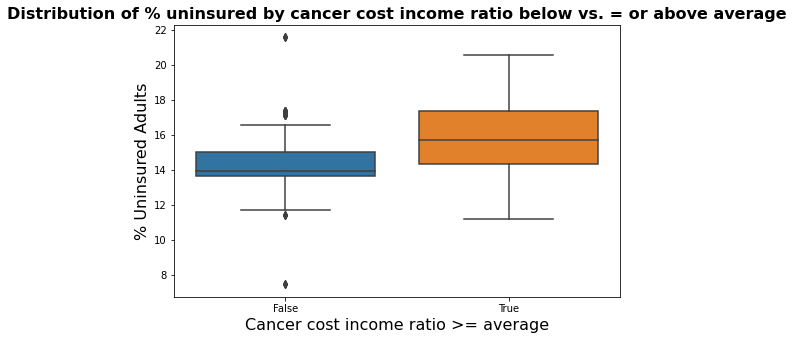

In [236]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Uninsured adults % Uninsured'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Uninsured Adults', fontsize = 16)
plt.title('Distribution of % uninsured by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')

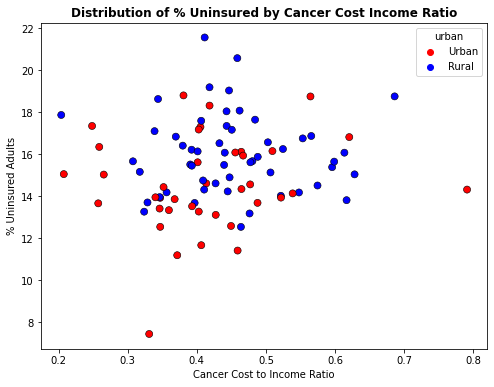

In [396]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'cancer_cost_income_ratio', y = 'Uninsured adults % Uninsured', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Cancer Cost to Income Ratio')
plt.ylabel('% Uninsured Adults',)
plt.title('Distribution of % Uninsured by Cancer Cost Income Ratio', fontweight = 'bold');

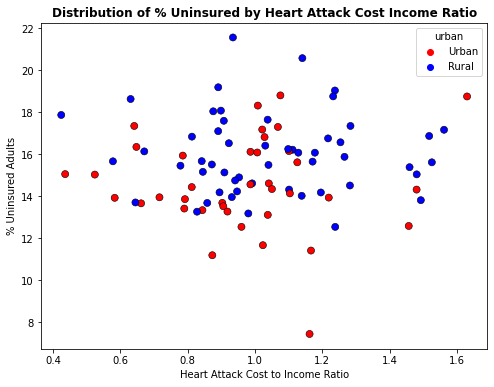

In [397]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'ha_cost_income_ratio', y = 'Uninsured adults % Uninsured', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Heart Attack Cost to Income Ratio')
plt.ylabel('% Uninsured Adults',)
plt.title('Distribution of % Uninsured by Heart Attack Cost Income Ratio', fontweight = 'bold');

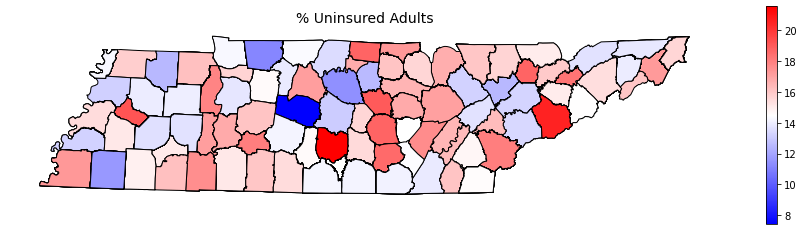

In [173]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn2[geo_tn2.Uninsured_adults_per_Uninsured.notnull()].plot(column = 'Uninsured_adults_per_Uninsured',
                    cmap = 'bwr',
                    edgecolor = 'black',
                    legend = True,
                    ax = ax)
plt.title('% Uninsured Adults', fontsize = 14)
ax.axis('off');

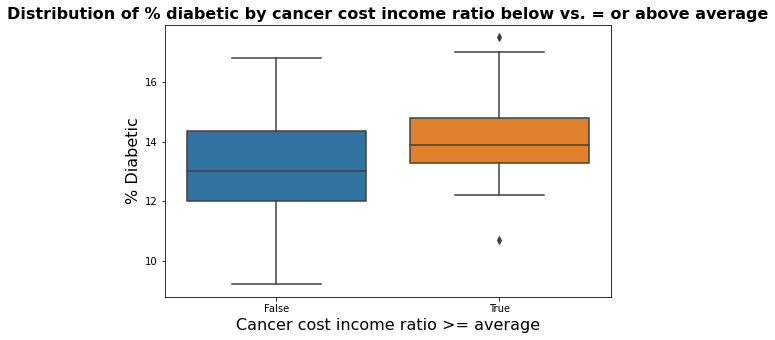

In [70]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Diabetes prevalence % Diabetic'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Diabetic', fontsize = 16)
plt.title('Distribution of % diabetic by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')

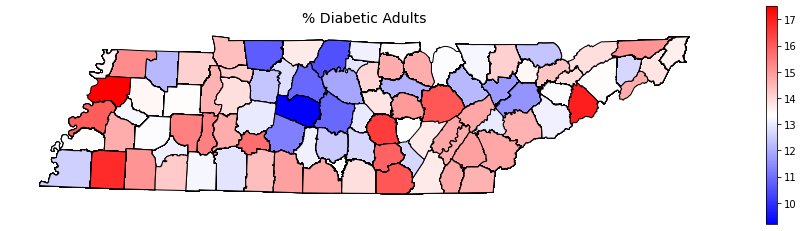

In [383]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn2[geo_tn2.Diabetes_prev_perc.notnull()].plot(column = 'Diabetes_prev_perc',
                    cmap = 'bwr',
                    edgecolor = 'black',
                    legend = True,
                    ax = ax)
plt.title('% Diabetic Adults', fontsize = 14)
ax.axis('off');

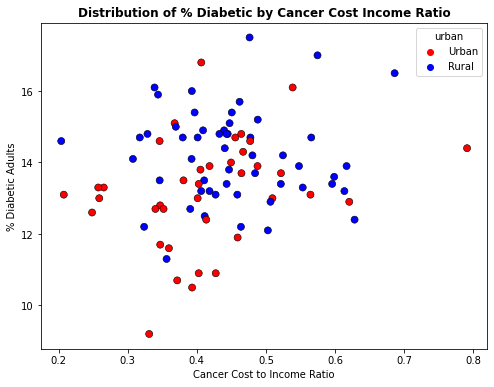

In [398]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'cancer_cost_income_ratio', y = 'Diabetes prevalence % Diabetic', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Cancer Cost to Income Ratio')
plt.ylabel('% Diabetic Adults',)
plt.title('Distribution of % Diabetic by Cancer Cost Income Ratio', fontweight = 'bold');

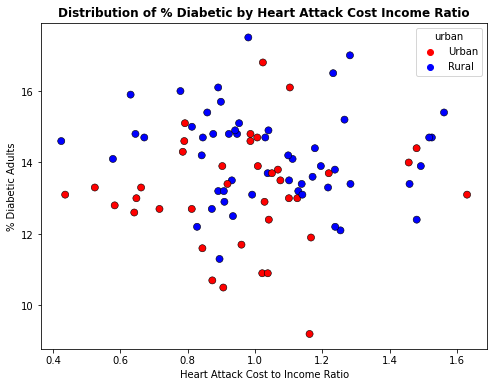

In [399]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'ha_cost_income_ratio', y = 'Diabetes prevalence % Diabetic', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Heart Attack Cost to Income Ratio')
plt.ylabel('% Diabetic Adults',)
plt.title('Distribution of % Diabetic by Heart Attack Cost Income Ratio', fontweight = 'bold');

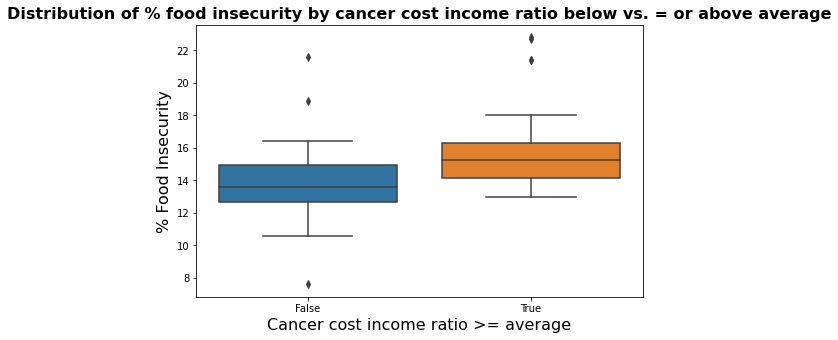

In [71]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Food insecurity % Food Insecure'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Food Insecurity', fontsize = 16)
plt.title('Distribution of % food insecurity by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')


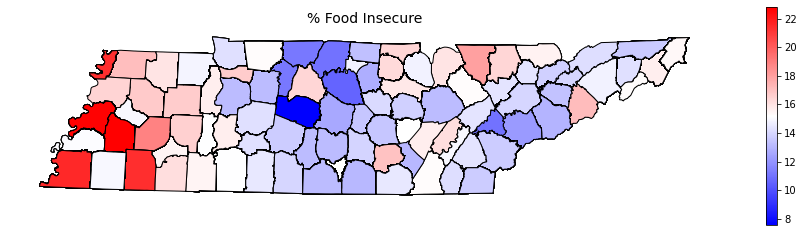

In [387]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn2[geo_tn2.Food_insecure_perc.notnull()].plot(column = 'Food_insecure_perc',
                    cmap = 'bwr',
                    edgecolor = 'black',
                    legend = True,
                    ax = ax)
plt.title('% Food Insecure', fontsize = 14)
ax.axis('off');

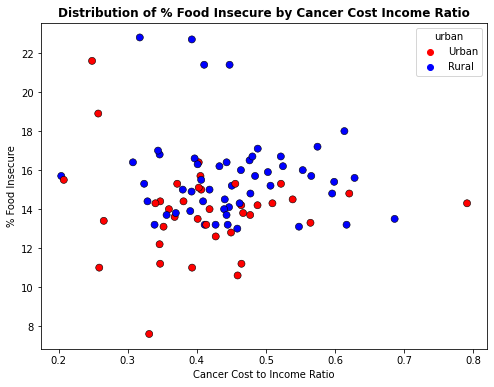

In [400]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'cancer_cost_income_ratio', y = 'Food insecurity % Food Insecure', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Cancer Cost to Income Ratio')
plt.ylabel('% Food Insecure',)
plt.title('Distribution of % Food Insecure by Cancer Cost Income Ratio', fontweight = 'bold');

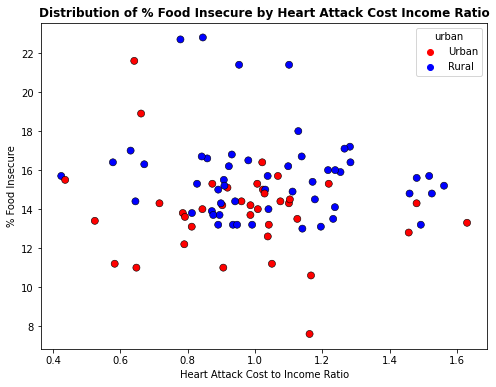

In [401]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'ha_cost_income_ratio', y = 'Food insecurity % Food Insecure', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Heart Attack Cost to Income Ratio')
plt.ylabel('% Food Insecure',)
plt.title('Distribution of % Food Insecure by Heart Attack Cost Income Ratio', fontweight = 'bold');

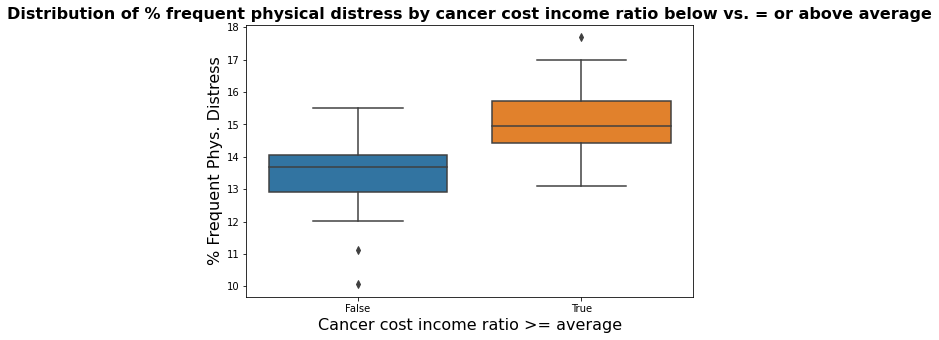

In [72]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Frequent physical distress % Frequent Physical Distress'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Frequent Phys. Distress', fontsize = 16)
plt.title('Distribution of % frequent physical distress by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('') 

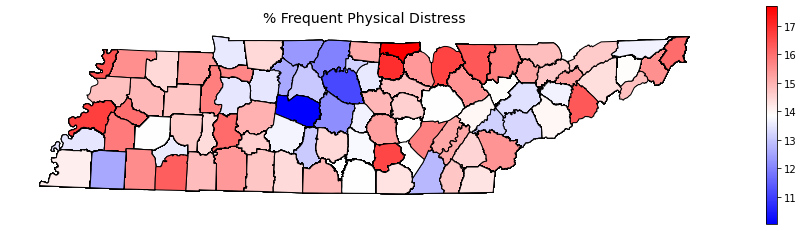

In [391]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn2[geo_tn2.Freq_phys_distress_perc.notnull()].plot(column = 'Freq_phys_distress_perc',
                    cmap = 'bwr',
                    edgecolor = 'black',
                    legend = True,
                    ax = ax)
plt.title('% Frequent Physical Distress', fontsize = 14)
ax.axis('off');

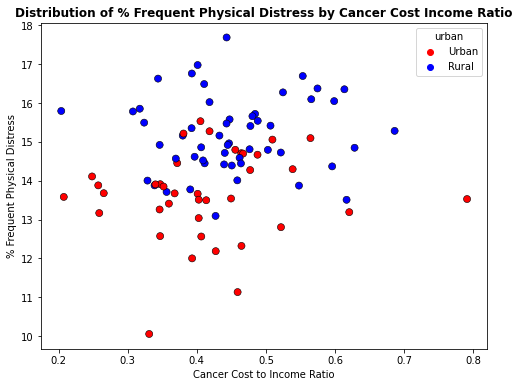

In [402]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'cancer_cost_income_ratio', y = 'Frequent physical distress % Frequent Physical Distress', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Cancer Cost to Income Ratio')
plt.ylabel('% Frequent Physical Distress',)
plt.title('Distribution of % Frequent Physical Distress by Cancer Cost Income Ratio', fontweight = 'bold');

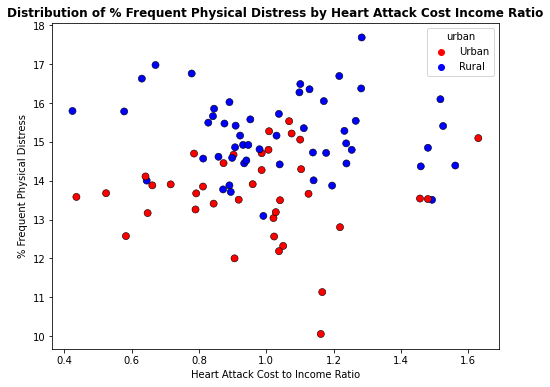

In [403]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = TN_Full_df2_clean, x = 'ha_cost_income_ratio', y = 'Frequent physical distress % Frequent Physical Distress', s = 50,
                hue='urban',
                palette = ['red', 'blue'],
                edgecolor = 'black')
plt.xlabel('Heart Attack Cost to Income Ratio')
plt.ylabel('% Frequent Physical Distress',)
plt.title('Distribution of % Frequent Physical Distress by Heart Attack Cost Income Ratio', fontweight = 'bold');

# End of code for presentation

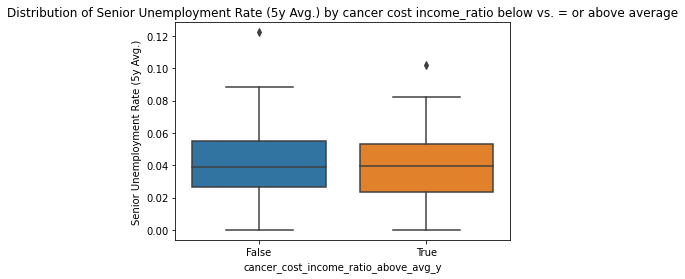

In [60]:
sns.boxplot(y=TN_Full_df['Senior Unemployment Rate (5y Avg.)'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.title('Distribution of Senior Unemployment Rate (5y Avg.) by cancer cost income_ratio below vs. = or above average');
#plt.xlabel('')

Build and evaluate a `RandomForestClassifier` 'NOT NEEDED FOR PRESENTATION'!

In [61]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [62]:
y_pred_train = tree.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

1.0


In [63]:
y_pred = tree.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.6988906497622821


In [64]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=1000)

In [65]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.7892234548335975


In [66]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7527733755942948


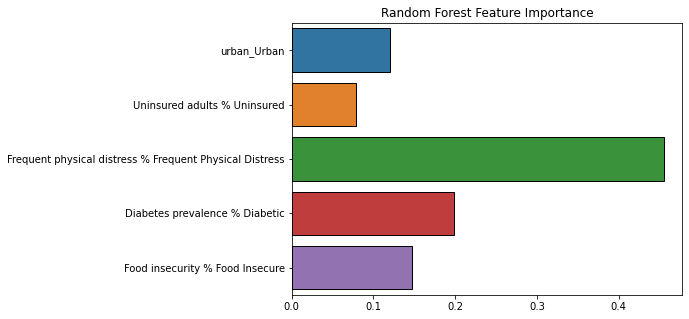

In [67]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance');

In [413]:
TN_Full_df2_clean.head(5)

,county,state,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income_x,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average),Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,approx_avg_income_y,approx_avg_income_x,county2,approx_avg_income_y
0,Anderson County,TN,Urban,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,0.041965,44241.0,2.710177,51.399863,5631.0,13.911728,12.539248,13.550779,0.867570,11.7,14.4,35.819313,3.954646,9.359187,0.959786,0.346968,0.408521,False,44540.114613,44540.114613,Anderson,44540.114613
1,Bedford County,TN,Rural,19219,43661,47127.581262,971152,36,0.061397,0.162543,0.072189,0.030724,43819.0,11.787128,50.840283,5980.0,14.448689,21.562759,13.911517,3.232674,12.5,13.2,36.252518,7.370904,6.622556,0.934468,0.411341,0.408521,False,46722.832244,46722.832244,Bedford,46722.832244
2,Benton County,TN,Rural,21315,44423,41296.671710,269227,36,0.110525,0.226498,0.149043,0.038647,33611.0,2.285500,50.693143,1648.0,15.795907,17.870310,15.192168,1.369241,14.6,15.7,37.092253,2.435369,6.564157,0.424309,0.203591,0.408521,True,104695.022984,104695.022984,Benton,104695.022984
3,Bledsoe County,TN,Rural,19250,41240,39743.640351,178860,36,0.093023,0.237262,0.145402,0.070796,38535.0,2.166951,41.574106,1259.0,15.720713,17.645410,14.761657,0.386188,13.7,15.7,36.760964,6.678024,1.637994,1.037650,0.484354,0.408521,True,39743.640351,39743.640351,Bledsoe,39743.640351
4,Blount County,TN,Urban,17073,38968,56786.162888,3333654,36,0.065083,0.135709,0.076359,0.029956,49532.0,3.203544,51.478977,10141.0,13.260458,13.410828,13.048794,0.828124,14.6,12.2,33.487183,2.873242,11.627353,0.789894,0.346075,0.408521,False,49333.197648,49333.197648,Blount,49333.197648


In [416]:
TN_Full_df3 = TN_Full_df2[['county', 'state', 'urban', 'cancer_avg_cost', 'ha_avg_cost', 'Uninsured adults % Uninsured', 'Frequent physical distress % Frequent Physical Distress', 'Diabetes prevalence % Diabetic', 'Food insecurity % Food Insecure', 'ha_cost_income_ratio', 'cancer_cost_income_ratio']]
TN_Full_df3.head(5)

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
0,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
1,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
2,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
3,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
4,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968


In [421]:
TN_Full_df3_clean = TN_Full_df3.groupby('county').first().reset_index()
pd.set_option('display.max_rows', 100)
TN_Full_df3_clean

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
0,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
1,Bedford County,TN,Rural,19219,43661,21.562759,14.448689,12.5,13.2,0.934468,0.411341
2,Benton County,TN,Rural,21315,44423,17.870310,15.795907,14.6,15.7,0.424309,0.203591
3,Bledsoe County,TN,Rural,19250,41240,17.645410,15.720713,13.7,15.7,1.037650,0.484354
4,Blount County,TN,Urban,17073,38968,13.410828,13.260458,14.6,12.2,0.789894,0.346075
5,Bradley County,TN,Urban,18859,40068,16.115236,14.709113,14.8,14.2,0.986558,0.464348
6,Campbell County,TN,Rural,20066,37715,15.662548,15.783713,14.1,16.4,0.577862,0.307447
7,Cannon County,TN,Urban,18036,50604,15.615293,13.663831,13.0,13.5,1.125658,0.401201
8,Carroll County,TN,Rural,20510,44771,14.018332,14.726590,13.4,16.7,1.138745,0.521669
9,Carter County,TN,Urban,17175,45266,17.299428,15.532703,13.8,15.7,1.068026,0.405235


In [418]:
TN_Full_df3_clean.shape

(91, 11)

In [424]:
TN_Full_df3_clean2 = TN_Full_df3_clean.sort_values(by = 'Uninsured adults % Uninsured')
TN_Full_df3_clean2

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
89,Williamson County,TN,Urban,17527,61541,7.435073,10.055718,9.2,7.6,1.162160,0.330985
61,Montgomery County,TN,Urban,20341,47799,11.187171,14.453506,10.7,15.3,0.873182,0.371585
90,Wilson County,TN,Urban,20618,52387,11.409807,11.134040,11.9,10.6,1.166397,0.459060
23,Fayette County,TN,Urban,17075,43000,11.665031,12.564618,16.8,15.0,1.023470,0.406413
87,Weakley County,TN,Rural,20655,55139,12.537133,14.445496,12.2,16.0,1.238319,0.463873
0,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
76,Smith County,TN,Urban,17623,57109,12.581197,13.542387,14.0,12.8,1.456761,0.449535
71,Rutherford County,TN,Urban,18443,44794,13.109379,12.187335,10.9,12.6,1.037974,0.427364
22,Dyer County,TN,Rural,22400,46084,13.177140,14.810858,17.5,16.5,0.980119,0.476405
62,Morgan County,TN,Rural,17089,43704,13.261618,15.495391,12.2,15.3,0.827801,0.323684


In [425]:
TN_Full_df3_clean3 = TN_Full_df3_clean.sort_values(by = 'cancer_avg_cost')
TN_Full_df3_clean3

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
0,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
36,Haywood County,TN,Rural,15531,41355,15.160295,15.854210,14.7,22.8,0.845065,0.317367
59,Meigs County,TN,Rural,16240,44088,16.407725,15.161491,14.7,15.0,1.030554,0.379609
17,Cumberland County,TN,Rural,16473,43307,17.099738,13.881149,16.1,13.2,0.890589,0.338760
51,Loudon County,TN,Urban,16617,41607,16.347318,13.168432,13.0,11.0,0.647619,0.258646
73,Sequatchie County,TN,Urban,16698,38547,14.434437,13.850660,12.7,13.1,0.812105,0.351792
33,Hardeman County,TN,Rural,16830,35835,14.897287,15.579806,15.1,21.4,0.952695,0.447436
4,Blount County,TN,Urban,17073,38968,13.410828,13.260458,14.6,12.2,0.789894,0.346075
23,Fayette County,TN,Urban,17075,43000,11.665031,12.564618,16.8,15.0,1.023470,0.406413
62,Morgan County,TN,Rural,17089,43704,13.261618,15.495391,12.2,15.3,0.827801,0.323684


In [426]:
TN_Full_df3_clean4 = TN_Full_df3_clean.sort_values(by = 'ha_avg_cost')
TN_Full_df3_clean4

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
42,Jackson County,TN,Rural,18432,30831,16.134700,16.978634,14.7,16.3,0.671017,0.401160
10,Cheatham County,TN,Urban,19198,32279,13.921820,12.575178,12.8,11.2,0.583163,0.346837
28,Grainger County,TN,Urban,20036,33698,15.933986,14.699805,14.3,13.8,0.785497,0.467037
69,Roane County,TN,Rural,18196,35713,13.701604,14.004182,14.8,14.4,0.644771,0.328515
33,Hardeman County,TN,Rural,16830,35835,14.897287,15.579806,15.1,21.4,0.952695,0.447436
43,Jefferson County,TN,Urban,18316,36201,15.029820,13.679616,13.3,13.4,0.524122,0.265181
85,Washington County,TN,Urban,17256,36346,13.947602,13.906637,12.7,14.3,0.716156,0.340009
6,Campbell County,TN,Rural,20066,37715,15.662548,15.783713,14.1,16.4,0.577862,0.307447
78,Sullivan County,TN,Urban,17559,37799,13.859155,13.675069,15.1,13.6,0.791861,0.367848
66,Polk County,TN,Urban,18447,38126,14.561739,14.275621,14.6,13.7,0.986347,0.477237


In [427]:
TN_Full_df3_clean5 = TN_Full_df3_clean.sort_values(by = 'Frequent physical distress % Frequent Physical Distress')
TN_Full_df3_clean5

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
89,Williamson County,TN,Urban,17527,61541,7.435073,10.055718,9.2,7.6,1.162160,0.330985
90,Wilson County,TN,Urban,20618,52387,11.409807,11.134040,11.9,10.6,1.166397,0.459060
79,Sumner County,TN,Urban,20373,46941,13.520520,12.002153,10.5,11.0,0.905814,0.393135
71,Rutherford County,TN,Urban,18443,44794,13.109379,12.187335,10.9,12.6,1.037974,0.427364
70,Robertson County,TN,Urban,18809,42519,14.341419,12.322678,13.7,11.2,1.050321,0.464627
23,Fayette County,TN,Urban,17075,43000,11.665031,12.564618,16.8,15.0,1.023470,0.406413
10,Cheatham County,TN,Urban,19198,32279,13.921820,12.575178,12.8,11.2,0.583163,0.346837
32,Hamilton County,TN,Urban,19272,45021,13.932967,12.804899,13.7,15.3,1.219154,0.521880
18,Davidson County,TN,Urban,20019,50778,17.175651,13.039284,10.9,16.4,1.021512,0.402727
55,Marshall County,TN,Rural,20413,47383,14.610678,13.094654,13.1,13.2,0.991501,0.427147


In [428]:
TN_Full_df3_clean6 = TN_Full_df3_clean.sort_values(by = 'Diabetes prevalence % Diabetic')
TN_Full_df3_clean6

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
89,Williamson County,TN,Urban,17527,61541,7.435073,10.055718,9.2,7.6,1.162160,0.330985
79,Sumner County,TN,Urban,20373,46941,13.520520,12.002153,10.5,11.0,0.905814,0.393135
61,Montgomery County,TN,Urban,20341,47799,11.187171,14.453506,10.7,15.3,0.873182,0.371585
71,Rutherford County,TN,Urban,18443,44794,13.109379,12.187335,10.9,12.6,1.037974,0.427364
18,Davidson County,TN,Urban,20019,50778,17.175651,13.039284,10.9,16.4,1.021512,0.402727
56,Maury County,TN,Rural,18992,47702,14.182409,13.711688,11.3,13.7,0.894625,0.356185
45,Knox County,TN,Urban,18065,42392,13.335024,13.410829,11.6,14.0,0.843737,0.359551
0,Anderson County,TN,Urban,15454,42749,12.539248,13.911728,11.7,14.4,0.959786,0.346968
90,Wilson County,TN,Urban,20618,52387,11.409807,11.134040,11.9,10.6,1.166397,0.459060
67,Putnam County,TN,Rural,19650,48998,16.568260,14.795043,12.1,15.9,1.253979,0.502892


In [429]:
TN_Full_df3_clean7 = TN_Full_df3_clean.sort_values(by = 'Food insecurity % Food Insecure')
TN_Full_df3_clean7

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
89,Williamson County,TN,Urban,17527,61541,7.435073,10.055718,9.2,7.6,1.162160,0.330985
90,Wilson County,TN,Urban,20618,52387,11.409807,11.134040,11.9,10.6,1.166397,0.459060
79,Sumner County,TN,Urban,20373,46941,13.520520,12.002153,10.5,11.0,0.905814,0.393135
51,Loudon County,TN,Urban,16617,41607,16.347318,13.168432,13.0,11.0,0.647619,0.258646
70,Robertson County,TN,Urban,18809,42519,14.341419,12.322678,13.7,11.2,1.050321,0.464627
10,Cheatham County,TN,Urban,19198,32279,13.921820,12.575178,12.8,11.2,0.583163,0.346837
4,Blount County,TN,Urban,17073,38968,13.410828,13.260458,14.6,12.2,0.789894,0.346075
71,Rutherford County,TN,Urban,18443,44794,13.109379,12.187335,10.9,12.6,1.037974,0.427364
76,Smith County,TN,Urban,17623,57109,12.581197,13.542387,14.0,12.8,1.456761,0.449535
74,Sevier County,TN,Rural,18174,45205,20.577949,14.010767,13.1,13.0,1.140744,0.458619


In [430]:
TN_Full_df3_clean8 = TN_Full_df3_clean.sort_values(by = 'ha_cost_income_ratio')
TN_Full_df3_clean8

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
2,Benton County,TN,Rural,21315,44423,17.870310,15.795907,14.6,15.7,0.424309,0.203591
11,Chester County,TN,Urban,23421,49264,15.052411,13.583716,13.1,15.5,0.435987,0.207276
43,Jefferson County,TN,Urban,18316,36201,15.029820,13.679616,13.3,13.4,0.524122,0.265181
6,Campbell County,TN,Rural,20066,37715,15.662548,15.783713,14.1,16.4,0.577862,0.307447
10,Cheatham County,TN,Urban,19198,32279,13.921820,12.575178,12.8,11.2,0.583163,0.346837
30,Grundy County,TN,Rural,22627,41492,18.630532,16.629016,15.9,17.0,0.630433,0.343797
75,Shelby County,TN,Urban,19836,51240,17.346074,14.110608,12.6,21.6,0.641266,0.248246
69,Roane County,TN,Rural,18196,35713,13.701604,14.004182,14.8,14.4,0.644771,0.328515
51,Loudon County,TN,Urban,16617,41607,16.347318,13.168432,13.0,11.0,0.647619,0.258646
53,Madison County,TN,Urban,17830,45861,13.660011,13.881418,13.3,18.9,0.661531,0.257192


In [431]:
TN_Full_df3_clean9 = TN_Full_df3_clean.sort_values(by = 'cancer_cost_income_ratio')
TN_Full_df3_clean9

,county,state,urban,cancer_avg_cost,ha_avg_cost,Uninsured adults % Uninsured,Frequent physical distress % Frequent Physical Distress,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,ha_cost_income_ratio,cancer_cost_income_ratio
2,Benton County,TN,Rural,21315,44423,17.870310,15.795907,14.6,15.7,0.424309,0.203591
11,Chester County,TN,Urban,23421,49264,15.052411,13.583716,13.1,15.5,0.435987,0.207276
75,Shelby County,TN,Urban,19836,51240,17.346074,14.110608,12.6,21.6,0.641266,0.248246
53,Madison County,TN,Urban,17830,45861,13.660011,13.881418,13.3,18.9,0.661531,0.257192
51,Loudon County,TN,Urban,16617,41607,16.347318,13.168432,13.0,11.0,0.647619,0.258646
43,Jefferson County,TN,Urban,18316,36201,15.029820,13.679616,13.3,13.4,0.524122,0.265181
6,Campbell County,TN,Rural,20066,37715,15.662548,15.783713,14.1,16.4,0.577862,0.307447
36,Haywood County,TN,Rural,15531,41355,15.160295,15.854210,14.7,22.8,0.845065,0.317367
62,Morgan County,TN,Rural,17089,43704,13.261618,15.495391,12.2,15.3,0.827801,0.323684
69,Roane County,TN,Rural,18196,35713,13.701604,14.004182,14.8,14.4,0.644771,0.328515
